## **MISCELLANEOUS**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/Shareddrives/Projeto DACO/scripts code

In [ ]:
pip install torchinfo

In [ ]:
pip install import-ipynb

In [ ]:
import torch

from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.ops.focal_loss import sigmoid_focal_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from time import time
from tqdm import tqdm
from torchinfo import summary
import datetime
import importlib
import os
import argparse
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


## **DETECTION TASK**
---





In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
### DATALOADER ###

import import_ipynb
from dataloader import small_dataset

dataset_fold = 'windowing' # ['original', 'windowing']

#---------------------------------------------------------------#

### FEATURE EXTRACTOR ###

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_DETECTION = VGG16()
model_DETECTION.load_state_dict(torch.load('DETECTION VGG FINAL/VGG_detection_latest_model.pth'))
model_DETECTION.eval()

model_DETECTION.fc.register_forward_hook(get_activation('features'))

#---------------------------------------------------------------#

### DATA PROCESSING ###

# Data albumentations 
img_size = 224
aug = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size)
]

aug += [ToTensorV2()]
train_transforms = A.Compose(aug)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

class_weights_d = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1], 
              y=detection_dataset['presence'])

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123)

d_train_set, d_val_set, d_test_set = d_train_set.reset_index(drop=True), d_val_set.reset_index(drop=True), d_test_set.reset_index(drop=True)

d_train_set = small_dataset(d_train_set, dataset_fold, transforms)
d_val_set = small_dataset(d_val_set, dataset_fold, transforms)
d_test_set = small_dataset(d_test_set, dataset_fold, transforms)

d_tr = DataLoader(d_train_set)
d_val = DataLoader(d_val_set)
d_tst = DataLoader(d_test_set)

print ("\nLoaded \n")


Loading dataset

Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Loaded 



In [ ]:
### FEATURES FROM TRAINING
features_train = []
label_train = []

for img, label_d, label_c in tqdm(d_tr):
    for i in label_d:
          label_train.append(int(i.numpy()))

    pred = model_DETECTION(img)
    features = activation['features']
    features = torch.flatten(features, 1)
    features_train.append(features)

# Convert to 2D Array
features_train = np.vstack(features_train)

### FEATURES FROM VALIDATION
features_val = []
label_val = []

for img, label_d, label_c in tqdm(d_val):
    for i in label_d:
          label_val.append(int(i.numpy()))

    pred = model_DETECTION(img)
    features = activation['features']
    features = torch.flatten(features, 1)
    features_val.append(features)

# Convert to 2D Array
features_val = np.vstack(features_val)

### FEATURES FROM TEST
features_test = []
label_test = []

for img, label_d, label_c in tqdm(d_tst):
    for i in label_d:
          label_test.append(int(i.numpy()))

    pred = model_DETECTION(img)
    features = activation['features']
    features = torch.flatten(features, 1)
    features_test.append(features)

# Convert to 2D Array
features_test = np.vstack(features_test)

Maximum accuracy at: 0.8454901960784313 at K = 33


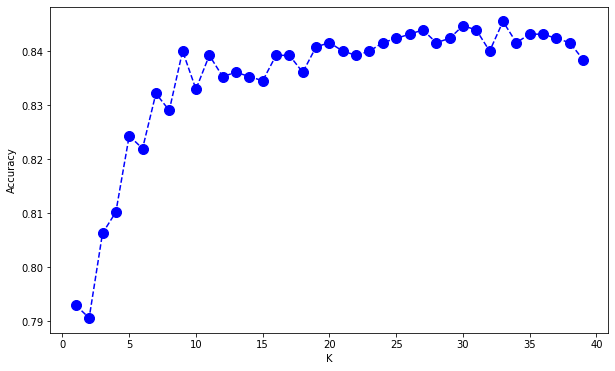

In [ ]:
# PLOT ACCURACY

from sklearn.neighbors import KNeighborsClassifier
accuracy_K = []

for k in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train, label_train)
    preds = knn.predict(features_val)
    accuracy = metrics.accuracy_score(label_val, y_pred=preds)

    accuracy_K.append(accuracy)

plt.figure(figsize=(10,6))
plt.plot(range(1,40),accuracy_K,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='blue', markersize=10)

plt.xlabel('K')
plt.ylabel('Accuracy')

print("Maximum accuracy at:",max(accuracy_K),"at K =",accuracy_K.index(max(accuracy_K))+1)

In [ ]:
# KNN

knn_DETECTION = KNeighborsClassifier(n_neighbors=33)
knn_DETECTION.fit(features_train, label_train)

pred_labels = knn_DETECTION.predict(features_test)
accuracy = metrics.accuracy_score(label_test, pred_labels)

sample_weights_d = [class_weights_d[i] for i in label_test]

print("Accuracy = ", accuracy)

Accuracy =  0.836078431372549


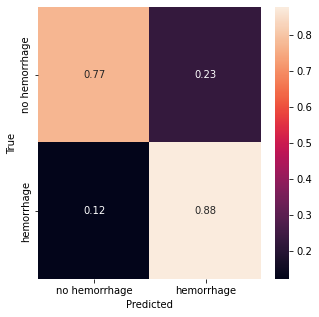

0.6515410098926412
0.8434670116429496
0.8763440860215054


In [ ]:
# CONFUSION MATRIX AND FINAL METRICS

import seaborn as sns

confusion_matrix = metrics.confusion_matrix(label_test, pred_labels, labels = [0,1])
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['hemorrhage','no hemorrhage'], yticklabels=['hemorrhage','no hemorrhage'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show(block=False)

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

m_coef = matthews_corrcoef(label_test, pred_labels, sample_weight=sample_weights_d)
precision = precision_score(label_test, pred_labels)
recall = recall_score(label_test, pred_labels)

print(m_coef)
print(precision)
print(recall)

## **CLASSIFICATION TASK**

---



In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
import import_ipynb
from dataloader import small_dataset

dataset_fold = 'windowing' # ['original', 'windowing']

#---------------------------------------------------------------#

### FEATURE EXTRACTOR ###

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_CLASSIFICATION = VGG16()
model_CLASSIFICATION.load_state_dict(torch.load('CLASSIFICATION VGG FINAL/VGG_classification_latest_model.pth'))
model_CLASSIFICATION.eval()

model_CLASSIFICATION.fc.register_forward_hook(get_activation('features'))

#---------------------------------------------------------------#

### DATA PROCESSING ###

# Data albumentations 
img_size = 224
aug = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size)
]

aug += [ToTensorV2()]
transforms = A.Compose(aug)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

label_encoder_2 = preprocessing.LabelEncoder()
detection_dataset ['type'] = label_encoder_2.fit_transform(detection_dataset ['type'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

print("\nClassification's Label Map")
print("Class 0 - ", label_encoder_2.inverse_transform([0]))
print("Class 1 - ", label_encoder_2.inverse_transform([1]))
print("Class 2 - ", label_encoder_2.inverse_transform([2]))
print("Class 3 - ", label_encoder_2.inverse_transform([3]))
print("Class 4 - ", label_encoder_2.inverse_transform([4]))
print("Class 5 - ", label_encoder_2.inverse_transform([5]))

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123)

# The classification dataset corresponds to the detection dataset with hemorrhage presence
classification_dataset = detection_dataset[detection_dataset['presence']==0]

# computed before eliminating the images for the test dataset
class_weights_c = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1, 2, 3, 4], 
              y=classification_dataset['type'])

c_test_set = d_test_set[d_test_set['presence']==0] # This ensures that the images with ICH used in the d_test_set are the same used in c_test_set

# The following two lines ensure that the images used to split the dataset into training and validation DO NOT include the c_test_set ones
cond = c_test_set['ID'].isin(classification_dataset['ID'])
classification_dataset.drop(c_test_set['ID'].index, inplace = True)

c_train_set, c_val_set = train_test_split(classification_dataset, test_size=0.15, random_state=123)

c_train_set, c_val_set, c_test_set = c_train_set.reset_index(drop=True), c_val_set.reset_index(drop=True), c_test_set.reset_index(drop=True)

c_train_set = small_dataset(c_train_set, dataset_fold, transforms)
c_val_set = small_dataset(c_val_set, dataset_fold, transforms)
c_test_set = small_dataset(c_test_set, dataset_fold, transforms)

c_tr = DataLoader(c_train_set)
c_val = DataLoader(c_val_set)
c_tst = DataLoader(c_test_set)

print ("\nLoaded \n")

In [ ]:
### FEATURES FROM TRAINING
features_train = []
label_train = []

for img, label_d, label_c in tqdm(c_tr):
    for i in label_c:
          label_train.append(int(i.numpy()))

    pred = model_CLASSIFICATION(img)
    features = activation['features']
    features = torch.flatten(features, 1)
    features_train.append(features)

# Convert to 2D Array
features_train = np.vstack(features_train)

### FEATURES FROM VALIDATION
features_val = []
label_val = []

for img, label_d, label_c in tqdm(c_val):
    for i in label_c:
          label_val.append(int(i.numpy()))

    pred = model_CLASSIFICATION(img)
    features = activation['features']
    features = torch.flatten(features, 1)
    features_val.append(features)

# Convert to 2D Array
features_val = np.vstack(features_val)

### FEATURES FROM TEST
features_test = []
label_test = []

for img, label_d, label_c in tqdm(c_tst):
    for i in label_c:
          label_test.append(int(i.numpy()))

    pred = model_CLASSIFICATION(img)
    features = activation['features']
    features = torch.flatten(features, 1)
    features_test.append(features)

# Convert to 2D Array
features_test = np.vstack(features_test)

Maximum accuracy at: 0.6539325842696629 at K = 14


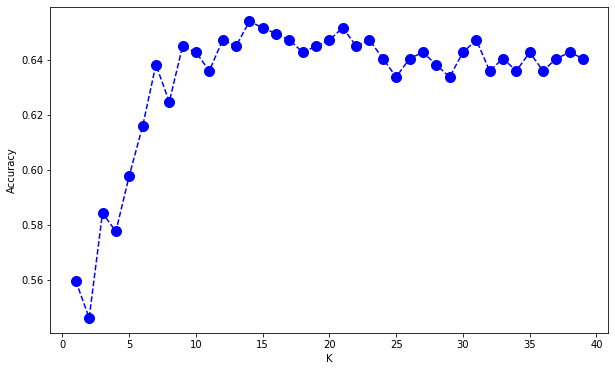

In [ ]:
# PLOT ACCURACY

from sklearn.neighbors import KNeighborsClassifier
accuracy_K = []

for k in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train, label_train)
    preds = knn.predict(features_val)
    accuracy = metrics.accuracy_score(label_val, y_pred=preds)

    accuracy_K.append(accuracy)

plt.figure(figsize=(10,6))
plt.plot(range(1,40),accuracy_K,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='blue', markersize=10)

plt.xlabel('K')
plt.ylabel('Accuracy')

print("Maximum accuracy at:",max(accuracy_K),"at K =",accuracy_K.index(max(accuracy_K))+1)

In [ ]:
# KNN

knn_CLASSIFICATION = KNeighborsClassifier(n_neighbors=14)
knn_CLASSIFICATION.fit(features_train, label_train)

pred_labels = knn_CLASSIFICATION.predict(features_test)
accuracy = metrics.accuracy_score(label_test, pred_labels)

sample_weights_c = [class_weights_c[i] for i in label_test]

print("Accuracy = ", accuracy)

Accuracy =  0.6365348399246704


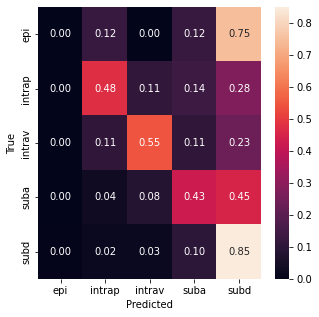

0.37100182926941183
0.6286225046294367
0.6365348399246704


In [ ]:
# CONFUSION MATRIX

import seaborn as sns

confusion_matrix = metrics.confusion_matrix(label_test, pred_labels, labels = [0,1,2,3,4])
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['epi','intrap','intrav','suba','subd'], yticklabels=['epi','intrap','intrav','suba','subd'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show(block=False)

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

m_coef = matthews_corrcoef(label_test, pred_labels, sample_weight=sample_weights_c)
precision = precision_score(label_test, pred_labels, average='weighted')
recall = recall_score(label_test, pred_labels, average='weighted')

print(m_coef)
print(precision)
print(recall)

## **FULL PIPELINE**

---



In [ ]:
### DATA LOADING AND MODEL

# Data albumentations
aug_2 = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size),
    ToTensorV2()
]

transforms = A.Compose(aug_2)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

label_encoder_2 = preprocessing.LabelEncoder()
detection_dataset ['type'] = label_encoder_2.fit_transform(detection_dataset ['type'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

print("\nClassification's Label Map")
print("Class 0 - ", label_encoder_2.inverse_transform([0]))
print("Class 1 - ", label_encoder_2.inverse_transform([1]))
print("Class 2 - ", label_encoder_2.inverse_transform([2]))
print("Class 3 - ", label_encoder_2.inverse_transform([3]))
print("Class 4 - ", label_encoder_2.inverse_transform([4]))
print("Class 5 - ", label_encoder_2.inverse_transform([5]))

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123)

class_weights = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1, 2, 3, 4, 5], 
              y=detection_dataset['type'])

d_test_set = d_test_set.reset_index(drop=True)

d_test_set = small_dataset(d_test_set, dataset_fold, transforms)

dtest = DataLoader(d_test_set)

print ("\nLoaded \n")



Loading dataset

Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']

Loaded 



In [ ]:
### FEATURES FROM TEST
features_test = []
label_test = []
pred_labels = []
sample_weights = []

for img, label_d, label_c in tqdm(dtest):

    if label_d == 1:
      label_test.append(5) # New encoded label
      sample_weights.append(class_weights[5])
    else:
      label_test.append(int(label_c.detach().numpy()))
      sample_weights.append(class_weights[int(label_c.detach().numpy())])

    pred = model_DETECTION(img)
    features = activation['features']
    features = torch.flatten(features, 1)

    pred_label_detect = knn_DETECTION.predict(features)

    if pred_label_detect == 0:
      pred = model_CLASSIFICATION(img)
      features = activation['features']
      features = torch.flatten(features, 1)

      pred_label_class = knn_CLASSIFICATION.predict(features)

      pred_labels.append(pred_label_class[0])
    else:
      pred_labels.append(5)


100%|██████████| 1275/1275 [18:31<00:00,  1.15it/s]


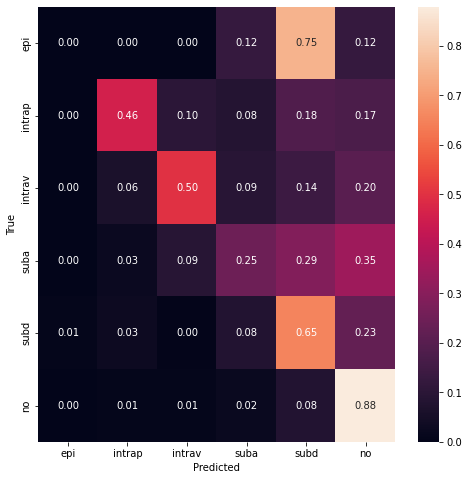

0.5291996731464106
0.7108506175093782
0.7215686274509804


In [ ]:
# CONFUSION MATRIX

import seaborn as sns

confusion_matrix = metrics.confusion_matrix(label_test, pred_labels, labels = [0,1,2,3,4,5])
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['epi','intrap','intrav','suba','subd','no'], yticklabels=['epi','intrap','intrav','suba','subd','no'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show(block=False)

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

m_coef = matthews_corrcoef(label_test, pred_labels, sample_weight = sample_weights)
precision = precision_score(label_test, pred_labels, average = 'weighted')
recall = recall_score(label_test, pred_labels, average = 'weighted')

print(m_coef)
print(precision)
print(recall)